In [7]:
import numpy as np
from scipy.stats import multivariate_normal


In [8]:

class EMGMM:
    def __init__(self, n_components, n_features, low_value=-4.0, high_value=4.0, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.n_features = n_features
        self.max_iter = max_iter
        self.tol = tol

        # Initialize parameters
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = np.random.uniform(low=low_value, high=high_value, size=(self.n_components, n_features))
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])


    def fit(self, X):
        log_likelihood_old = 0

        for iteration in range(self.max_iter):
            print(f"Iteration: {iteration + 1}/{self.max_iter} weights:{self.weights} means:{self.means}, nll: {-log_likelihood_old}")
            # E-step
            responsibilities = self._e_step(X)
            
            # M-step
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self._log_likelihood(X)
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood
    
    def _e_step(self, X):
        weighted_pdfs = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weighted_pdfs[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        responsibilities = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, responsibilities):
        N_k = responsibilities.sum(axis=0)
        self.weights = N_k / X.shape[0]
        self.means = (responsibilities.T @ X) / N_k[:, None]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k][:, None] * diff).T @ diff / N_k[k]

    def _log_likelihood(self, X):
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        return np.sum(np.log(log_likelihood))
    
    def predict(self, X):
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)


Iteration: 1/100 weights:[0.5 0.5] means:[[1.11159508 2.07228676]
 [1.79282663 1.09785264]], nll: 0
Iteration: 2/100 weights:[0.40882859 0.59117141] means:[[ 0.24550255  0.94334042]
 [-0.18715017 -0.63202279]], nll: 1172.1850300645317
Iteration: 3/100 weights:[0.41923787 0.58076213] means:[[ 0.25700321  0.93895803]
 [-0.20320686 -0.65709524]], nll: 1169.036350148091
Iteration: 4/100 weights:[0.4301322 0.5698678] means:[[ 0.27748986  0.95147064]
 [-0.22746801 -0.6970519 ]], nll: 1167.878662052841
Iteration: 5/100 weights:[0.44044144 0.55955856] means:[[ 0.30667683  0.97090576]
 [-0.25974503 -0.74272191]], nll: 1167.3522938246501
Iteration: 6/100 weights:[0.45008314 0.54991686] means:[[ 0.34314135  0.99484665]
 [-0.29952074 -0.79236153]], nll: 1166.9972180642035
Iteration: 7/100 weights:[0.45926705 0.54073295] means:[[ 0.38598709  1.02282439]
 [-0.34682651 -0.8464785 ]], nll: 1166.6479523873024
Iteration: 8/100 weights:[0.46820861 0.53179139] means:[[ 0.43526849  1.05508776]
 [-0.4025372

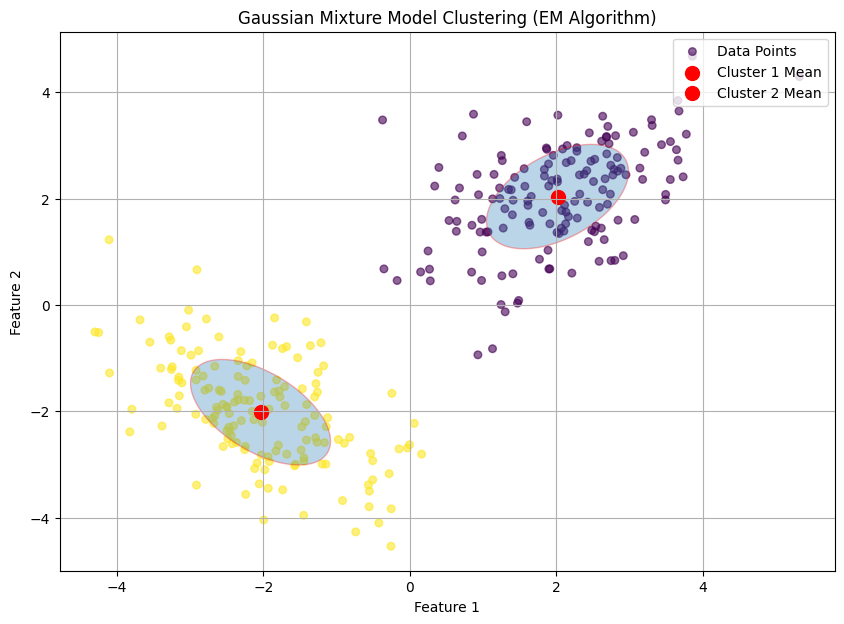

weights [0.50030562 0.49969438]
Means:
[[ 2.01600089  2.03924411]
 [-2.03901819 -2.01766236]]
Covariances:
[[[ 0.94170911  0.45404668]
  [ 0.45404668  0.96452705]]

 [[ 0.91420484 -0.51999377]
  [-0.51999377  0.9854529 ]]]
Cluster Assignments:
[0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0
 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1
 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1
 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1
 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1
 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0
 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0
 0 0 1 0]


In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_results(X, predictions, means, covariances):
    plt.figure(figsize=(10, 7))
    
    # Scatter plot of data points with cluster assignments
    plt.scatter(X[:, 0], X[:, 1], c=predictions, cmap='viridis', s=30, alpha=0.6, label="Data Points")
    
    # Plot Gaussian ellipses
    for i in range(len(means)):
        plot_gaussian_ellipse(means[i], covariances[i], edgecolor='red')
        plt.scatter(means[i][0], means[i][1], c='red', s=100, label=f"Cluster {i+1} Mean")
    
    plt.title("Gaussian Mixture Model Clustering (EM Algorithm)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

def plot_gaussian_ellipse(mean, covariance, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    eigvals, eigvecs = np.linalg.eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)
    # The angle is kwarg, openai make a mistake here
    ellipse = Ellipse(mean, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)
    ellipse.set_alpha(0.3)

# Generate synthetic data
np.random.seed(42)

mean1 = [2, 2]
cov1 = [[1, 0.5], [0.5, 1]]
mean2 = [-2, -2]
cov2 = [[1, -0.5], [-0.5, 1]]

data1 = np.random.multivariate_normal(mean1, cov1, 150)
data2 = np.random.multivariate_normal(mean2, cov2, 150)
X = np.vstack((data1, data2))
X = X[np.random.permutation(len(X))]


# Apply EM algorithm
em_gmm = EMGMM(n_components=2, n_features=len(mean1), max_iter=100)
em_gmm.fit(X)
predictions = em_gmm.predict(X)

# Visualize results
plot_results(X, predictions, em_gmm.means, em_gmm.covariances)


# Display results
print(f"weights {em_gmm.weights}")
print("Means:")
print(em_gmm.means)
print("Covariances:")
print(em_gmm.covariances)
print("Cluster Assignments:")
print(predictions)
